In [5]:
from imports_func import *
from dbase import *

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
#X=np.load('/home/miquel/ForMiquel/CLEAN2/X_c1_1j_full2.npy') 
#y=np.load('/home/miquel/ForMiquel/CLEAN2/y_1j_full2.npy') #subject labels
#sub_id=np.load('/home/miquel/ForMiquel/CLEAN2/sub_id_short.npy') #subject idxs
#jac_idx=np.load('/home/miquel/ForMiquel/CLEAN2/jac_idx_1j_full2.npy')

X=np.load('/home/miquel/ForMiquel/CLEAN2/X_c1_1j_1y.npy') 
y=np.load('/home/miquel/ForMiquel/CLEAN2/y_1j_1y.npy') #subject labels
sub_id=np.load('/home/miquel/ForMiquel/CLEAN2/sub_idx_1j_1y.npy') #subject idxs
jac_idx=np.load('/home/miquel/ForMiquel/CLEAN2/jac_idx_1j_1y.npy')

In [7]:
# build vector with dt's
dt=[]
for i in range(0,len(sub_id)):
    dt.append(Subjects[sub_id[i]].jacobians[jac_idx[i]].dt)

dt = np.asarray(dt)/365 
#dt=np.reshape(dt, (124,1))

In [29]:
def KFold_intern(X_train, y_train, folds, linspace, dt, percentage):
    
    l=len(linspace)
    l2=X_train.shape[0]
    TP=np.zeros((l))
    FP=np.zeros((l))
    FN=np.zeros((l))
    
    
    dt=np.reshape(dt, (l2,1))
    
    kf = cross_validation.KFold(l2, n_folds=folds)

    fold = 1
       
    for train_index_f, test_index_f in kf:  
        X_train_f = X_train[train_index_f,:]
        X_test_f = X_train[test_index_f,:]
        y_train_f = y_train[train_index_f]
        y_test_f = y_train[test_index_f]
        
        print("fold:", fold)
        fold = fold + 1
     
        tp_l=[]
        fp_l=[]
        fn_l=[]
        
        for c in linspace:
            
            y_test_f = y[test_index_f]
            dt_test_f = dt[test_index_f]
            
            clf = LogisticRegression(solver='liblinear', penalty='l2', C=c, class_weight=None)
            clf.fit(X_train_f, y_train_f)
            pred = clf.predict(X_test_f)
            conf = confusion_matrix(y_test_f, pred)
            
            #mask0 = np.where(dt_test_f>1.09)#~400 days
            #mask0 = np.asarray(mask0)
            #pred = pred[mask0][0]
            #y_test_f = y_test_f[mask0][0]
            conf = confusion_matrix(y_test_f, pred)
            tp_l.append(conf[1,1])
            fp_l.append(conf[0,1])
            fn_l.append(conf[1,0])
            
            
        TP = np.vstack((TP, tp_l))
        FP = np.vstack((FP, fp_l))
        FN = np.vstack((FN, fn_l))
        
            
    TP=TP[1:,:]
    FP=FP[1:,:]
    FN=FN[1:,:]
    
    TP=np.sum(TP, axis=0)
    FP=np.sum(FP, axis=0)
    FN=np.sum(FN, axis=0)
    
    F=(2*TP)/(2*TP + FP + FN)
    maxi = np.amax(F)
    maxi_idx = np.argmax(F)
    
    #plt.figure(1)
    #plt.plot(linspace, F, color='blue', label='F-measure')
    #plt.legend(loc='best')
    #plt.xlabel('C')
    #plt.title('metrics logistic regression combination c1 and c2')
    #plt.show()
    
    return maxi, maxi_idx

In [30]:
def nested_CV_F_measure(X, y, splits, folds, linspace, dt, percentage):
   
    SPECIFICITY=[]
    PRECISION=[]
    RECALL=[]
    AUC=[]
    F=[]
    tp_l=[]
    fp_l=[]
    fn_l=[]
    
    spl = StratifiedShuffleSplit(n_splits=splits, test_size=0.3, random_state=42)
    split=1
    
    for train_index, test_index in spl.split(X, y):
        X_train = X[train_index,:]
        y_train = y[train_index]
        X_test = X[test_index,:]
        y_test = y[test_index]
        dt_test = dt[test_index]
        dt_train = dt[train_index]
        print("split:", split)
        split = split + 1
        
        S = SelectPercentile(percentile=percentage)
        S.fit(X_train, y_train)
        
        X_train_s = X_train[:,S.get_support()]
        X_test_s = X_test[:,S.get_support()]
     
        maxi, maxi_idx = KFold_intern(X_train_s, y_train, folds, linspace, dt_train, percentage)
        c = linspace[maxi_idx]
        
        clf = LogisticRegression(solver='liblinear', penalty='l2', C=c, class_weight=None)
        clf.fit(X_train_s, y_train)
        pred = clf.predict(X_test_s)
        probas_ = clf.predict_proba(X_test_s)
        
        #mask0 = np.where(dt_test>1.09)#~400 days
        #mask0 = np.asarray(mask0)
        #pred = pred[mask0][0]
        #y_test = y_test[mask0][0]
        probas_ = probas_[:, 1]
        #probas_ = probas_[mask0][0]
        
        conf = confusion_matrix(y_test, pred)
        tp_l.append(conf[1,1])
        fp_l.append(conf[0,1])
        fn_l.append(conf[1,0])
        
        f1=f1_score(y_test, pred)
        F.append(f1)
        fpr, tpr, thresholds = roc_curve(y_test, probas_)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        AUC.append(roc_auc)
        precision=precision_score(y_test, pred)
        recall=recall_score(y_test, pred)
        PRECISION.append(precision)
        RECALL.append(recall)
        specificity= (conf[0,0])/(conf[0,0]+conf[0,1])
        print(specificity)
        SPECIFICITY.append(specificity)
    
    TP=np.sum(tp_l, axis=0)
    FP=np.sum(fp_l, axis=0)
    FN=np.sum(fn_l, axis=0)

    
    F_g=(2*TP)/(2*TP + FP + FN)

    
    print("F_mean:", np.mean(F))
    print("AUC_mean:", np.mean(AUC))
    print("PRECISION_mean:", np.mean(PRECISION))
    print("RECALL_mean:", np.mean(RECALL))
    print("SPECIFICITY_mean:", np.mean(SPECIFICITY))
    
    print("F_std:", np.std(F))
    print("AUC_std:", np.std(AUC))
    print("PRECISION_std:", np.std(PRECISION))
    print("RECALL_std:", np.std(RECALL))
    print("SPECIFICITY_std:", np.std(SPECIFICITY))
    
    return np.mean(F), np.mean(AUC), np.mean(PRECISION), np.mean(RECALL), np.mean(SPECIFICITY)
    

split: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    178 ..., 562823 562824 562825] are constant.
  UserWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


fold: 1
fold: 2
fold: 3


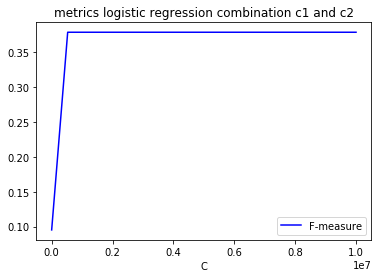

0.857142857143
split: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    178    179 ..., 562815 562816 562817] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


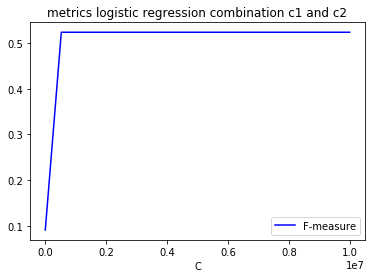

0.375
split: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    196    276 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


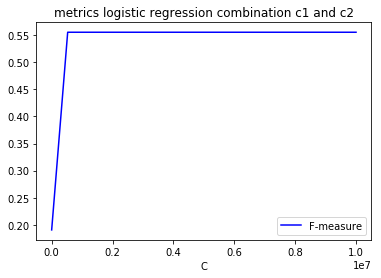

0.666666666667
split: 4


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    173 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


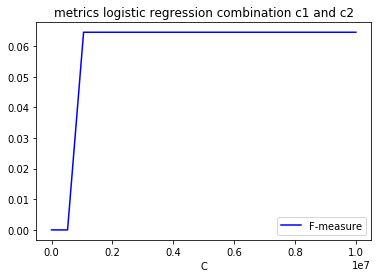

0.933333333333
split: 5


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    234 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


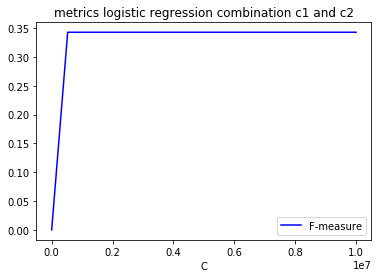

0.642857142857
split: 6


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     79     84 ..., 562823 562824 562825] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


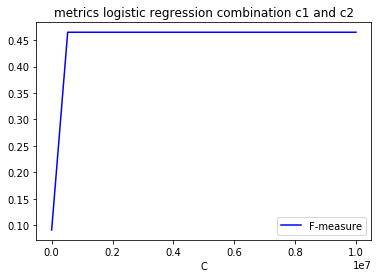

0.785714285714
split: 7


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   177    185    190 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


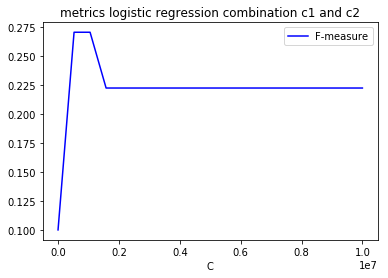

0.571428571429
split: 8


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     89    127 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


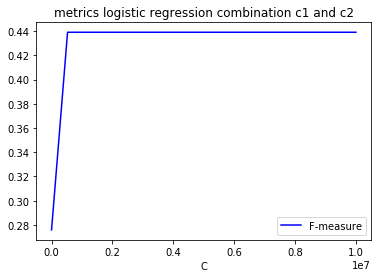

0.727272727273
split: 9
fold: 1
fold: 2
fold: 3


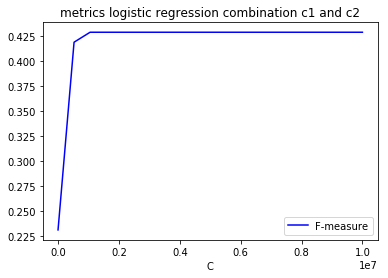

0.846153846154
split: 10


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     89    127 ..., 562795 562805 562806] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


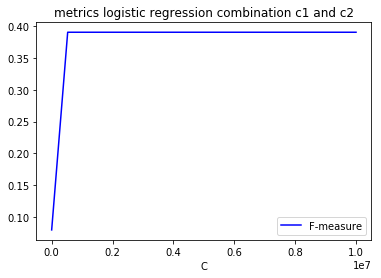

0.583333333333
split: 11


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    127 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


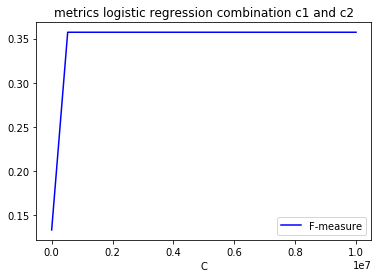

0.857142857143
split: 12


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     89    127 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


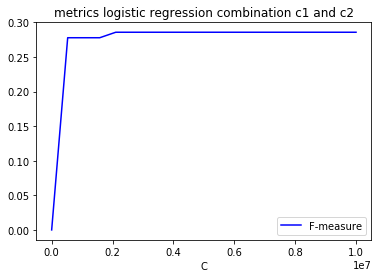

0.933333333333
split: 13


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    178 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


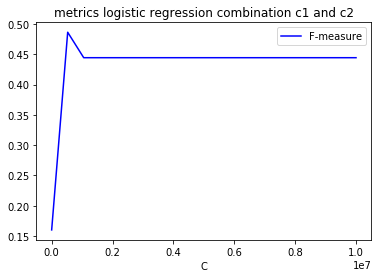

0.842105263158
split: 14


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    127 ..., 562838 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


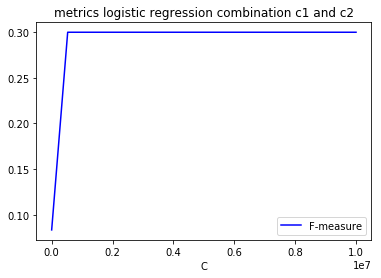

0.933333333333
split: 15


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    173 ..., 562823 562824 562825] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


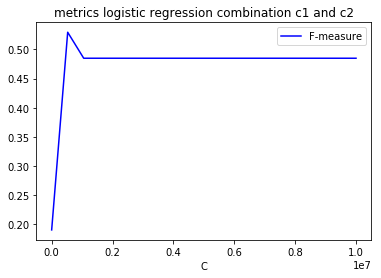

0.857142857143
split: 16


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    71    149    306 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


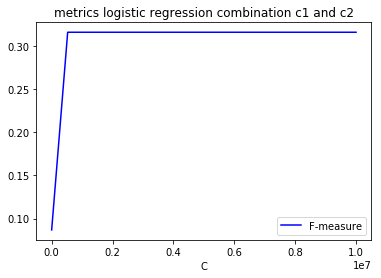

0.916666666667
split: 17


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    70     89    127 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


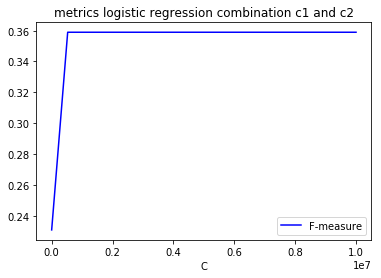

0.733333333333
split: 18


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    173 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


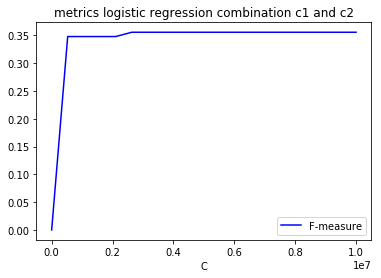

0.923076923077
split: 19


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    175 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


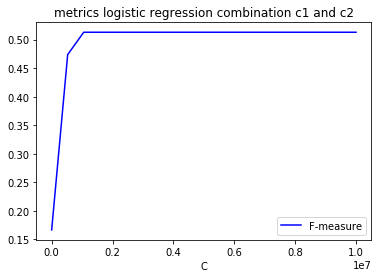

0.571428571429
split: 20


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    127    138 ..., 562838 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


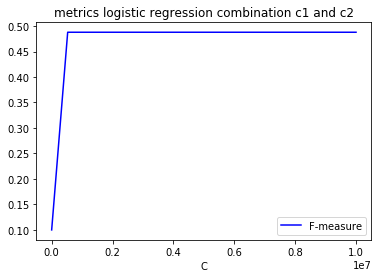

1.0
split: 21


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    71    149    275 ..., 562780 562788 562807] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


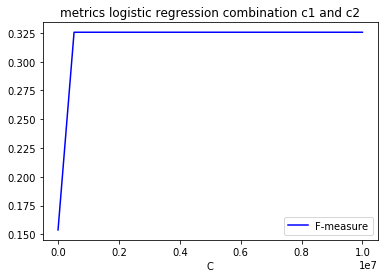

0.8
split: 22


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   178    179    183 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


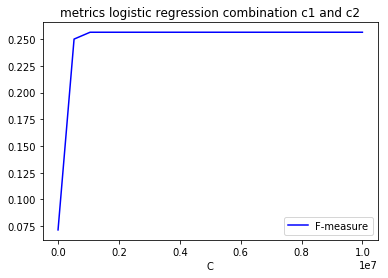

0.769230769231
split: 23


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84     89 ..., 562815 562816 562817] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


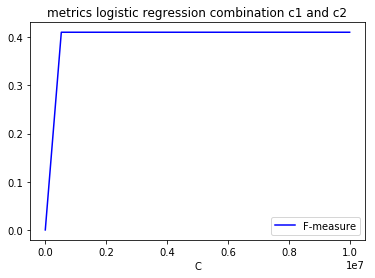

0.769230769231
split: 24


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    196    297 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


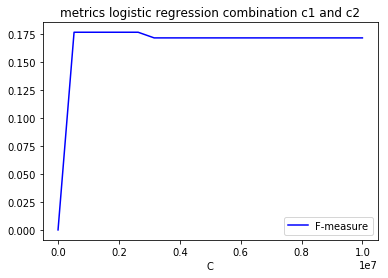

0.666666666667
split: 25
fold: 1
fold: 2
fold: 3


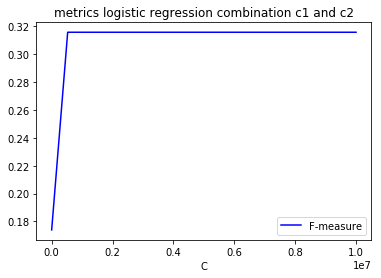

0.625
split: 26
fold: 1
fold: 2
fold: 3


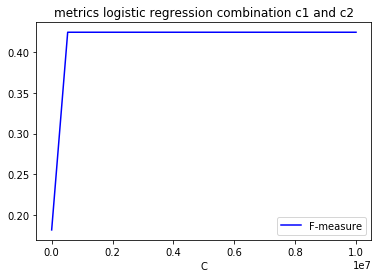

1.0
split: 27


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   284    345    346 ..., 562699 562787 562807] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


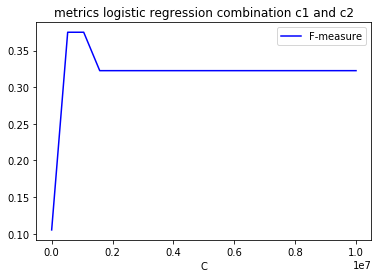

0.8125
split: 28


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     89    127 ..., 562823 562824 562825] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


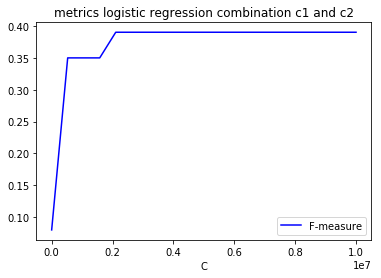

0.636363636364
split: 29


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   178    179    183 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


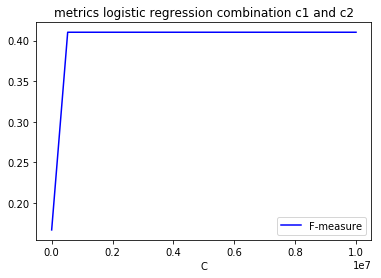

0.666666666667
split: 30


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    149 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


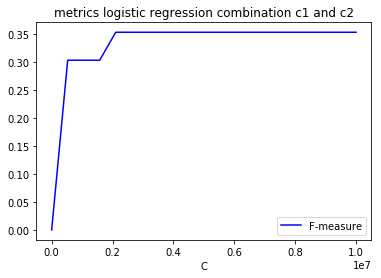

0.75
split: 31
fold: 1
fold: 2
fold: 3


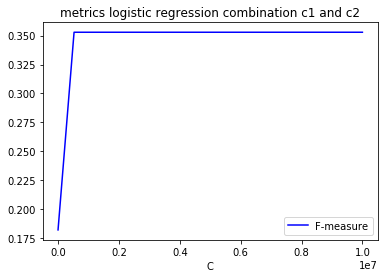

0.923076923077
split: 32


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     71     89 ..., 562823 562824 562825] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


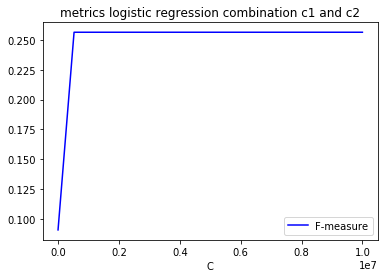

0.8
split: 33


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    276    290 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


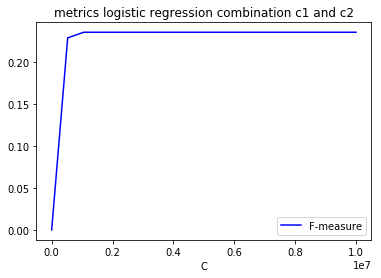

0.642857142857
split: 34


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    127    138 ..., 562691 562811 562812] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


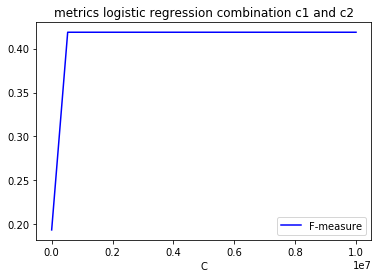

0.857142857143
split: 35


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    127 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


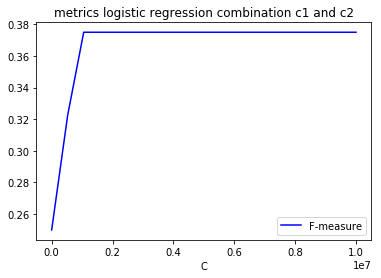

0.5625
split: 36


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    149 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


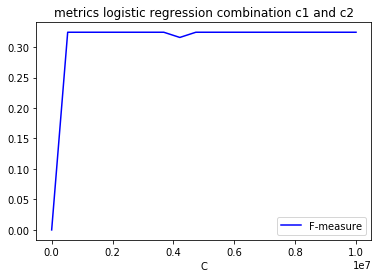

0.785714285714
split: 37


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    149 ..., 562558 562576 562788] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


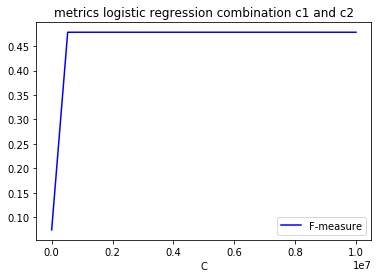

0.583333333333
split: 38


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84     89 ..., 562838 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


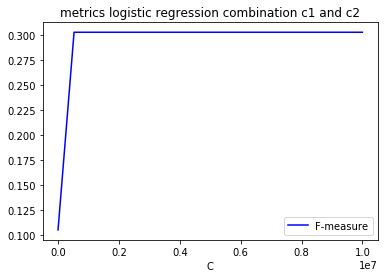

0.461538461538
split: 39


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    85    178    179 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


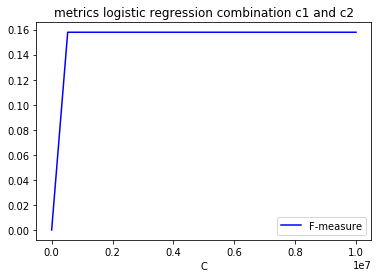

0.928571428571
split: 40
fold: 1
fold: 2
fold: 3


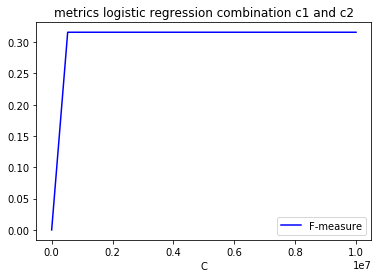

0.666666666667
split: 41


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    173 ..., 562815 562816 562817] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


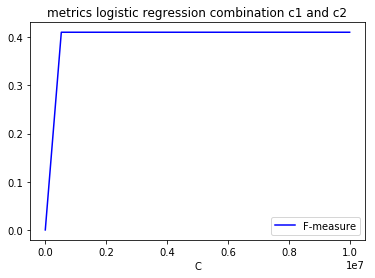

0.6
split: 42


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   178    179    183 ..., 562807 562811 562812] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


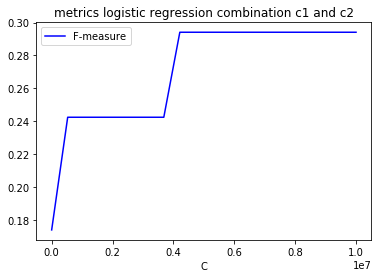

0.9375
split: 43
fold: 1
fold: 2
fold: 3


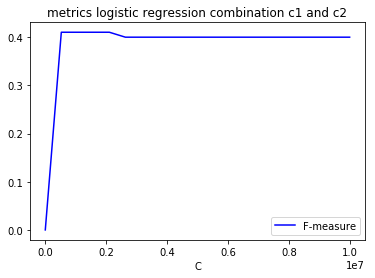

0.833333333333
split: 44


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    127 ..., 562823 562824 562825] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


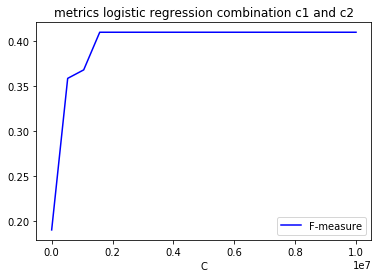

0.733333333333
split: 45


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   358    377    378 ..., 562815 562816 562817] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


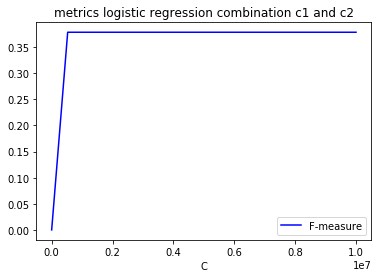

0.75
split: 46


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     79     84 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


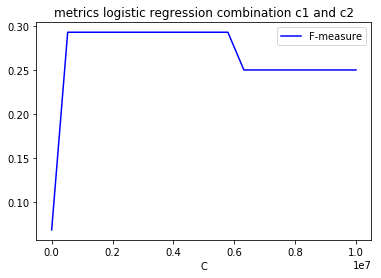

0.538461538462
split: 47


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    234 ..., 562724 562737 562788] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


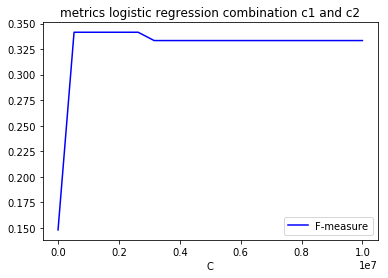

0.571428571429
split: 48


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     89    127 ..., 562838 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


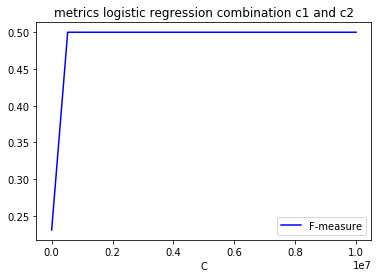

0.642857142857
split: 49


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    175    176 ..., 562838 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


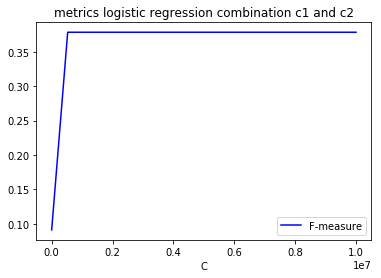

0.733333333333
split: 50
fold: 1
fold: 2
fold: 3


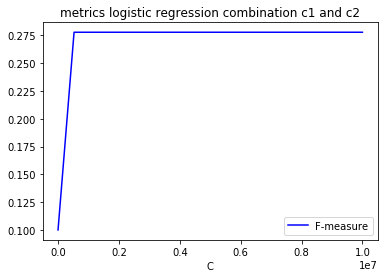

0.714285714286
split: 51


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   266    276    293 ..., 562795 562805 562806] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


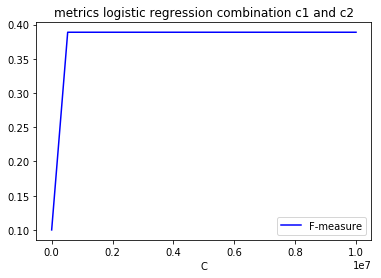

0.642857142857
split: 52


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84     89 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


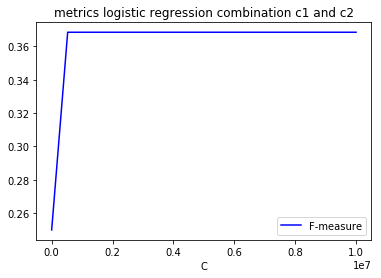

0.666666666667
split: 53


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    177    185 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


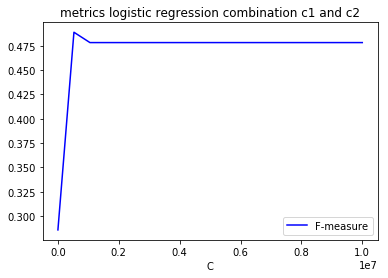

0.8
split: 54


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    149 ..., 562823 562824 562825] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


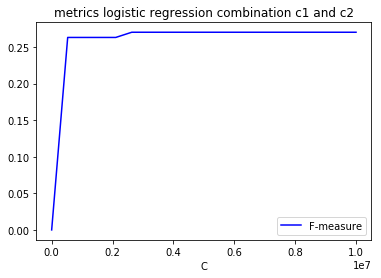

1.0
split: 55


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    352    353 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


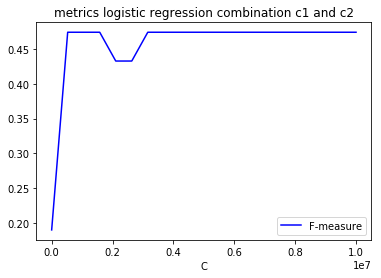

0.928571428571
split: 56


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    149    175 ..., 562838 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


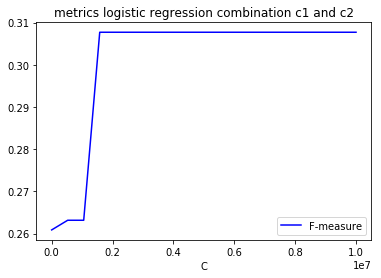

0.733333333333
split: 57


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84     89 ..., 562807 562811 562812] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


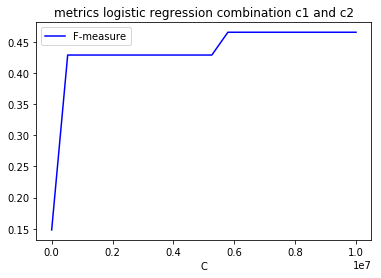

0.818181818182
split: 58
fold: 1
fold: 2
fold: 3


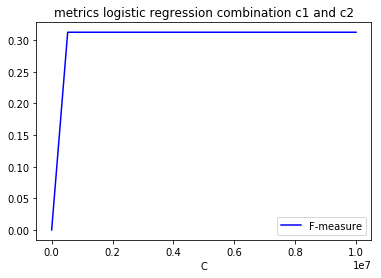

0.923076923077
split: 59


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   175    176    177 ..., 562838 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


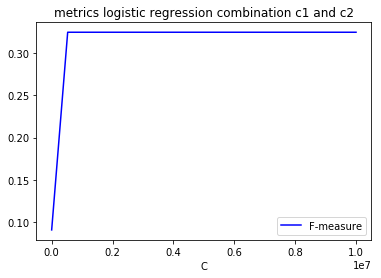

0.785714285714
split: 60


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    127    138 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


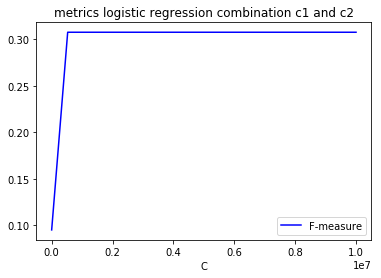

0.785714285714
split: 61


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   177    178    179 ..., 562838 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


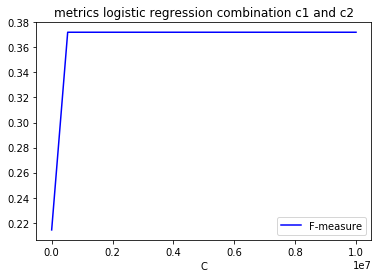

0.714285714286
split: 62
fold: 1
fold: 2
fold: 3


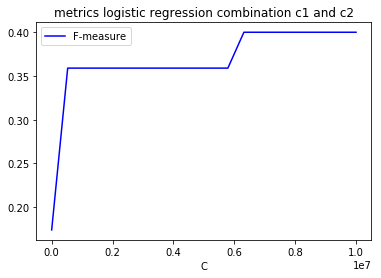

0.642857142857
split: 63


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    149 ..., 562805 562806 562807] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


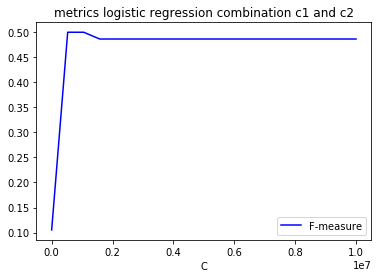

0.823529411765
split: 64


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    177 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


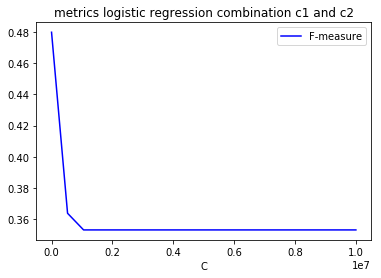

/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1.0
split: 65
fold: 1
fold: 2
fold: 3


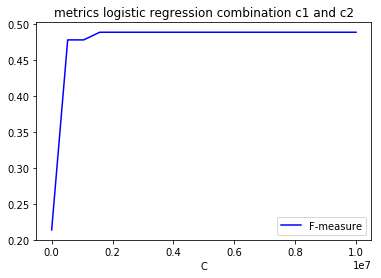

0.846153846154
split: 66
fold: 1
fold: 2
fold: 3


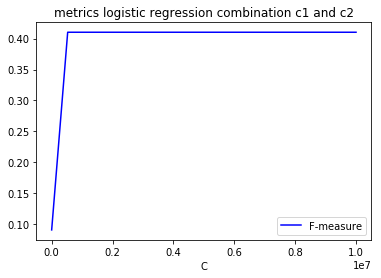

0.916666666667
split: 67


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    173 ..., 562795 562805 562806] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


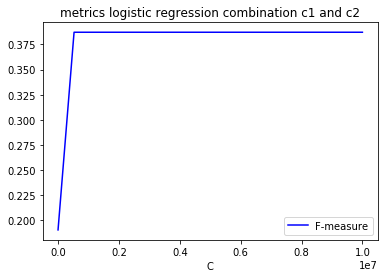

0.875
split: 68
fold: 1
fold: 2
fold: 3


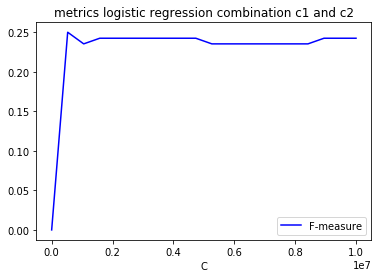

0.733333333333
split: 69


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    127 ..., 562806 562811 562812] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


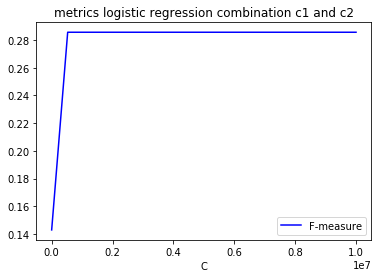

0.75
split: 70


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   284    290    394 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


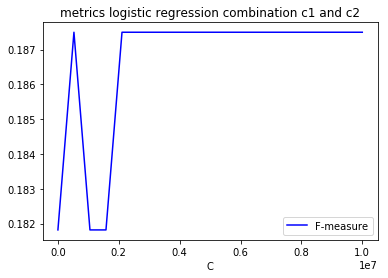

0.6875
split: 71


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    127    138 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


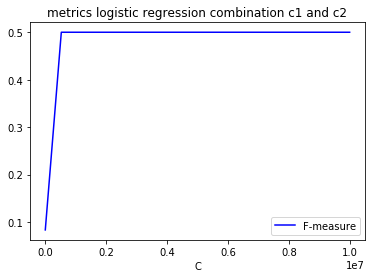

0.571428571429
split: 72


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84     89 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


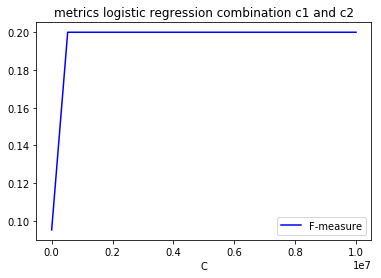

0.6
split: 73
fold: 1
fold: 2
fold: 3


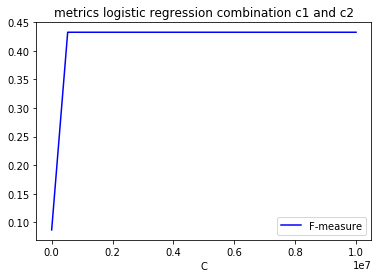

0.733333333333
split: 74
fold: 1
fold: 2
fold: 3


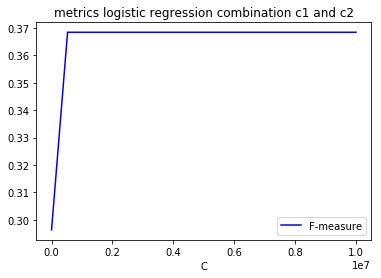

0.714285714286
split: 75


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    149 ..., 562838 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


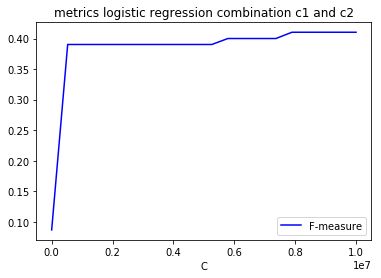

0.642857142857
split: 76
fold: 1
fold: 2
fold: 3


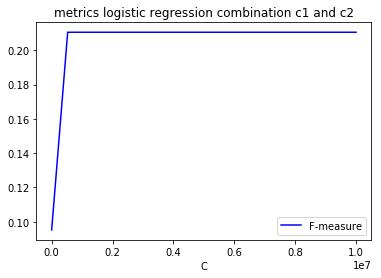

0.941176470588
split: 77
fold: 1
fold: 2
fold: 3


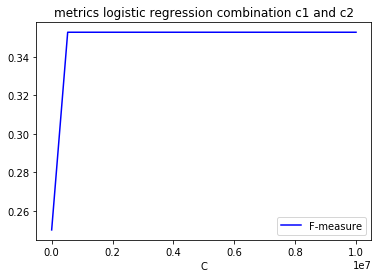

0.875
split: 78
fold: 1
fold: 2
fold: 3


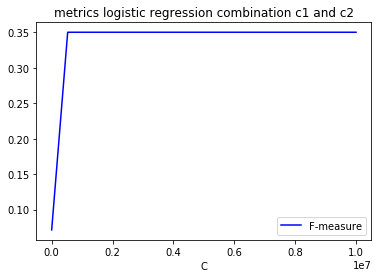

1.0
split: 79


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    149 ..., 562718 562765 562780] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


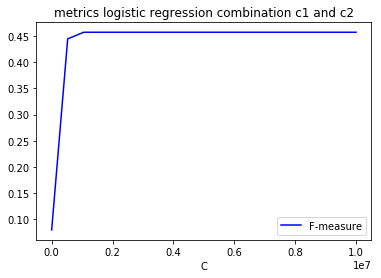

0.6875
split: 80


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    196    284 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


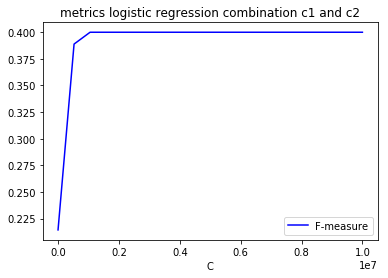

0.857142857143
split: 81


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    234 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


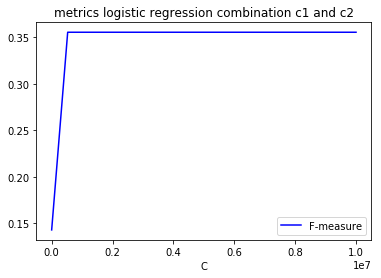

0.833333333333
split: 82


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    234 ..., 562788 562811 562812] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


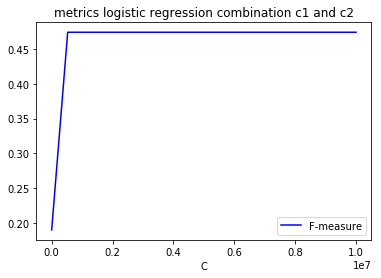

0.615384615385
split: 83
fold: 1
fold: 2
fold: 3


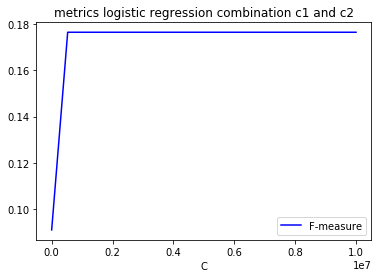

0.625
split: 84


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    234 ..., 562795 562805 562806] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


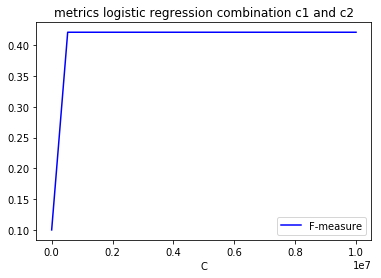

0.882352941176
split: 85
fold: 1
fold: 2
fold: 3


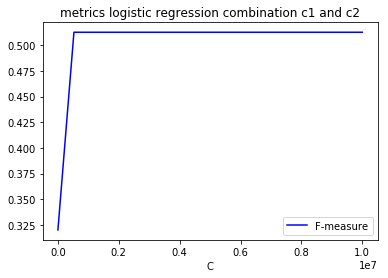

0.571428571429
split: 86


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   178    179    183 ..., 562823 562824 562825] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


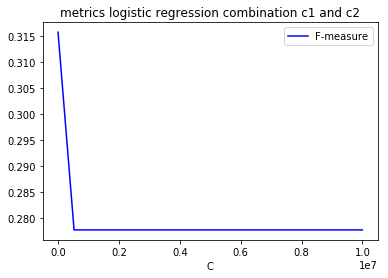

1.0
split: 87


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    127 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


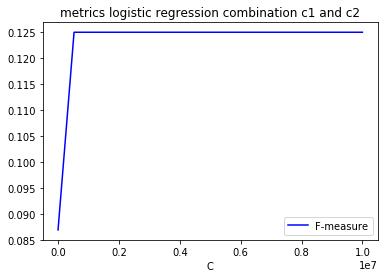

0.857142857143
split: 88
fold: 1
fold: 2
fold: 3


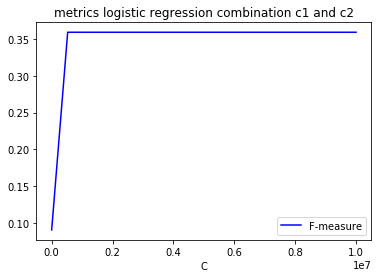

0.733333333333
split: 89
fold: 1
fold: 2
fold: 3


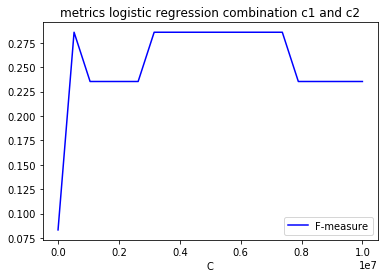

0.8125
split: 90
fold: 1
fold: 2
fold: 3


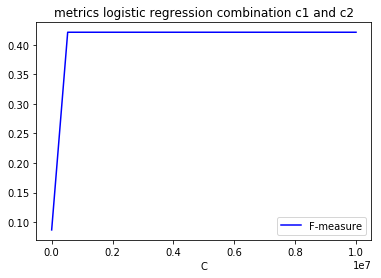

0.769230769231
split: 91


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   177    178    179 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


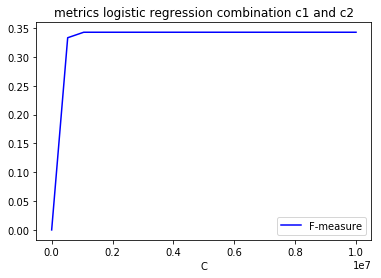

0.777777777778
split: 92
fold: 1
fold: 2
fold: 3


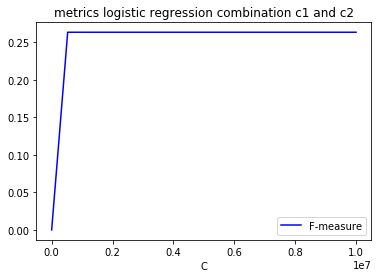

0.714285714286
split: 93


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    71     89    149 ..., 562815 562816 562817] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


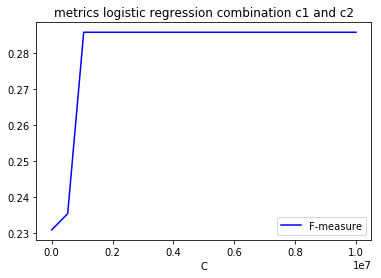

1.0
split: 94


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    173 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


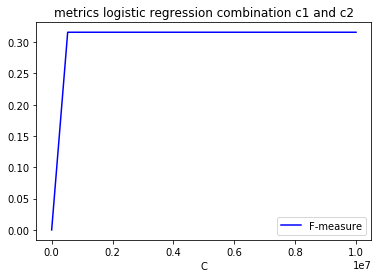

0.571428571429
split: 95
fold: 1
fold: 2
fold: 3


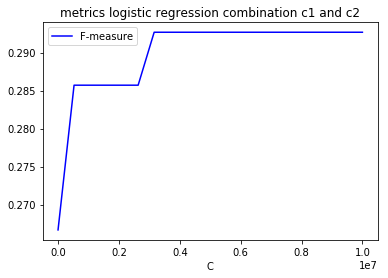

0.75
split: 96
fold: 1
fold: 2
fold: 3


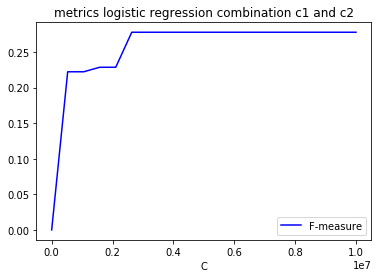

0.875
split: 97


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    149    196 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


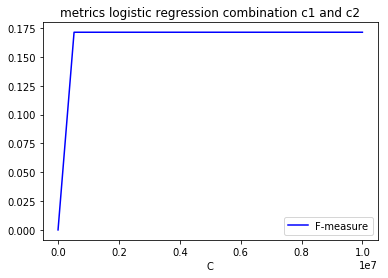

0.307692307692
split: 98


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    175    176 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


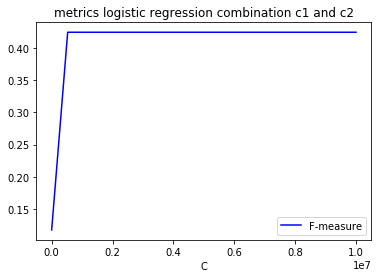

1.0
split: 99


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   266    290    345 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


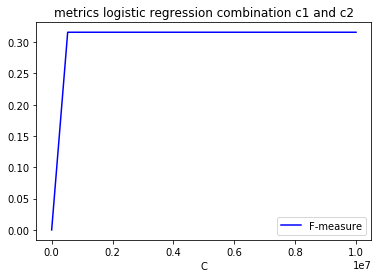

0.684210526316
split: 100


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    149 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3


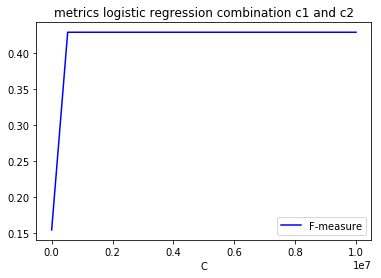

0.714285714286
F_mean: 0.523622834618
AUC_mean: 0.677916090145
PRECISION_mean: 0.578132909574
RECALL_mean: 0.515803030303
SPECIFICITY_mean: 0.761086115982
F_std: 0.16850282754
AUC_std: 0.107421984097
PRECISION_std: 0.204912875795
RECALL_std: 0.204121733837
SPECIFICITY_std: 0.143319626706


In [22]:
splits = 100
folds= 3
linspace = np.linspace(10e-6, 10e6, num=20)
percentage = 1.75
F, AUC, PRECISION, RECALL, SPECIFICITY = nested_CV_F_measure(X, y, splits, folds, linspace, dt, percentage)

In [ ]:
linspace = np.linspace(1, splits, num=splits)
plt.figure(figsize=(15,15))
plt.plot(linspace, F, color='green', label='F1_score')
plt.plot(linspace, AUC, color='red', label='AUC')
plt.plot(linspace, PRECISION, color='blue', label='PRECISION')
plt.plot(linspace, RECALL, color='orange', label='RECALL')
plt.plot(linspace, SPECIFICITY, color='pink', label='SPECIFICITY')



plt.legend(loc='best')
plt.xlabel('split')
plt.title('metrics for each split')
plt.show()
    

In [9]:
print("F:", F)
print()
print("AUC:", AUC)
print()
print("PRECISION:", PRECISION)
print()
print("RECALL:", RECALL)
print()
print("SPECIFICITY:", SPECIFICITY)

F: [0.625, 0.69565217391304346, 0.69230769230769229, 0.54545454545454541, 0.62068965517241381, 0.46666666666666662, 0.53846153846153855, 0.66666666666666674, 0.56000000000000005, 0.61538461538461542, 0.43478260869565216, 0.66666666666666663, 0.5, 0.6206896551724137, 0.18181818181818182, 0.66666666666666674, 0.5, 0.63157894736842102, 0.60869565217391308, 0.53846153846153855, 0.76923076923076916, 0.56000000000000005, 0.5714285714285714, 0.63157894736842102, 0.61538461538461531, 0.66666666666666652, 0.28571428571428575, 0.7272727272727274, 0.63636363636363635, 0.57142857142857151, 0.5, 0.40000000000000002, 0.69999999999999996, 0.58823529411764708, 0.40000000000000002, 0.55172413793103448, 0.14285714285714285, 0.59999999999999998, 0.55555555555555558, 0.77777777777777768, 0.68965517241379315, 0.76190476190476197, 0.5714285714285714, 0.54545454545454541, 0.44444444444444442, 0.5, 0.63157894736842102, 0.25, 0.70588235294117652, 0.47619047619047622, 0.70000000000000007, 0.55555555555555558, 0

percentage: 0.001
split: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    178 ..., 562823 562824 562825] are constant.
  UserWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


fold: 1
fold: 2
fold: 3
1.0


/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


split: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    178    179 ..., 562815 562816 562817] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    196    276 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 4


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    173 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 5


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    234 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 6


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     79     84 ..., 562823 562824 562825] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 7


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   177    185    190 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 8


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     89    127 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 9
fold: 1
fold: 2
fold: 3
1.0
split: 10


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     89    127 ..., 562795 562805 562806] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 11


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    127 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 12


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     89    127 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 13


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    178 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 14


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    127 ..., 562838 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 15


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    173 ..., 562823 562824 562825] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 16


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    71    149    306 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 17


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    70     89    127 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 18


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    173 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 19


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    175 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 20


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    127    138 ..., 562838 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 21


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    71    149    275 ..., 562780 562788 562807] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 22


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   178    179    183 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 23


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84     89 ..., 562815 562816 562817] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 24


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    196    297 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 25
fold: 1
fold: 2
fold: 3
1.0
split: 26
fold: 1
fold: 2
fold: 3
1.0
split: 27


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   284    345    346 ..., 562699 562787 562807] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 28


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     89    127 ..., 562823 562824 562825] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 29


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   178    179    183 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 30


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    149 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 31
fold: 1
fold: 2
fold: 3
1.0
split: 32


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     71     89 ..., 562823 562824 562825] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 33


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    276    290 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 34


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    127    138 ..., 562691 562811 562812] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 35


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    127 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 36


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    149 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 37


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    149 ..., 562558 562576 562788] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 38


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84     89 ..., 562838 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 39


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    85    178    179 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 40
fold: 1
fold: 2
fold: 3
1.0
split: 41


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    173 ..., 562815 562816 562817] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 42


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   178    179    183 ..., 562807 562811 562812] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 43
fold: 1
fold: 2
fold: 3
1.0
split: 44


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    127 ..., 562823 562824 562825] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 45


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   358    377    378 ..., 562815 562816 562817] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 46


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     79     84 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 47


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    234 ..., 562724 562737 562788] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 48


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     89    127 ..., 562838 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 49


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    175    176 ..., 562838 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 50
fold: 1
fold: 2
fold: 3
1.0
split: 51


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   266    276    293 ..., 562795 562805 562806] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 52


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84     89 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 53


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    177    185 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 54


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    149 ..., 562823 562824 562825] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 55


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    352    353 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 56


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    149    175 ..., 562838 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 57


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84     89 ..., 562807 562811 562812] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 58
fold: 1
fold: 2
fold: 3
1.0
split: 59


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   175    176    177 ..., 562838 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 60


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    127    138 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 61


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   177    178    179 ..., 562838 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 62
fold: 1
fold: 2
fold: 3
1.0
split: 63


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    149 ..., 562805 562806 562807] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 64


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    177 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 65
fold: 1
fold: 2
fold: 3
1.0
split: 66
fold: 1
fold: 2
fold: 3
1.0
split: 67


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    173 ..., 562795 562805 562806] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 68
fold: 1
fold: 2
fold: 3
1.0
split: 69


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    127 ..., 562806 562811 562812] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 70


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   284    290    394 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 71


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    127    138 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 72


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84     89 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 73
fold: 1
fold: 2
fold: 3
1.0
split: 74
fold: 1
fold: 2
fold: 3
1.0
split: 75


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    149 ..., 562838 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 76
fold: 1
fold: 2
fold: 3
1.0
split: 77
fold: 1
fold: 2
fold: 3
1.0
split: 78
fold: 1
fold: 2
fold: 3
1.0
split: 79


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    149 ..., 562718 562765 562780] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 80


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    196    284 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 81


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    234 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 82


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    234 ..., 562788 562811 562812] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 83
fold: 1
fold: 2
fold: 3
1.0
split: 84


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    234 ..., 562795 562805 562806] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 85
fold: 1
fold: 2
fold: 3
1.0
split: 86


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   178    179    183 ..., 562823 562824 562825] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 87


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    127 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 88
fold: 1
fold: 2
fold: 3
1.0
split: 89
fold: 1
fold: 2
fold: 3
1.0
split: 90
fold: 1
fold: 2
fold: 3
1.0
split: 91


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   177    178    179 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 92
fold: 1
fold: 2
fold: 3
1.0
split: 93


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    71     89    149 ..., 562815 562816 562817] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 94


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    173 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 95
fold: 1
fold: 2
fold: 3
1.0
split: 96
fold: 1
fold: 2
fold: 3
1.0
split: 97


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    149    196 ..., 562836 562839 562840] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 98


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    175    176 ..., 562834 562835 562838] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 99


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   266    290    345 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
split: 100


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    149 ..., 562831 562832 562833] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
1.0
F_mean: 0.0
AUC_mean: 0.548205128205
PRECISION_mean: 0.0
RECALL_mean: 0.0
SPECIFICITY_mean: 1.0
F_std: 0.0
AUC_std: 0.0926055140881
PRECISION_std: 0.0
RECALL_std: 0.0
SPECIFICITY_std: 0.0
percentage: 0.052
split: 1
fold: 1
fold: 2
fold: 3
1.0
split: 2
fold: 1
fold: 2
fold: 3
1.0
split: 3
fold: 1
fold: 2
fold: 3
1.0
split: 4
fold: 1
fold: 2
fold: 3
1.0
split: 5
fold: 1
fold: 2
fold: 3
1.0
split: 6
fold: 1
fold: 2
fold: 3
1.0
split: 7
fold: 1
fold: 2
fold: 3
1.0
split: 8
fold: 1
fold: 2
fold: 3
1.0
split: 9
fold: 1
fold: 2
fold: 3
1.0
split: 10
fold: 1
fold: 2
fold: 3
1.0
split: 11
fold: 1
fold: 2
fold: 3
1.0
split: 12
fold: 1
fold: 2
fold: 3
1.0
split: 13
fold: 1
fold: 2
fold: 3
1.0
split: 14
fold: 1
fold: 2
fold: 3
1.0
split: 15
fold: 1
fold: 2
fold: 3
1.0
split: 16
fold: 1
fold: 2
fold: 3
1.0
split: 17
fold: 1
fold: 2
fold: 3
1.0
split: 18
fold: 1
fold: 2
fold: 3
1.0
split: 19
fold: 1
fold: 2
fold: 3
1.0
split: 20
fold: 1
fold: 2
fold: 3
1.0
split: 21
fold:

split: 100
fold: 1
fold: 2
fold: 3
1.0
F_mean: 0.0165336134454
AUC_mean: 0.609157509158
PRECISION_mean: 0.0991666666667
RECALL_mean: 0.00923076923077
SPECIFICITY_mean: 0.99380952381
F_std: 0.0482367352214
AUC_std: 0.0981582466901
PRECISION_std: 0.291951051833
RECALL_std: 0.027261607918
SPECIFICITY_std: 0.0209253071835
percentage: 0.154
split: 1
fold: 1
fold: 2
fold: 3
1.0
split: 2
fold: 1
fold: 2
fold: 3
1.0
split: 3
fold: 1
fold: 2
fold: 3
1.0
split: 4
fold: 1
fold: 2
fold: 3
1.0
split: 5
fold: 1
fold: 2
fold: 3
1.0
split: 6
fold: 1
fold: 2
fold: 3
1.0
split: 7
fold: 1
fold: 2
fold: 3
1.0
split: 8
fold: 1
fold: 2
fold: 3
0.952380952381
split: 9
fold: 1
fold: 2
fold: 3
1.0
split: 10
fold: 1
fold: 2
fold: 3
1.0
split: 11
fold: 1
fold: 2
fold: 3
1.0
split: 12
fold: 1
fold: 2
fold: 3
1.0
split: 13
fold: 1
fold: 2
fold: 3
1.0
split: 14
fold: 1
fold: 2
fold: 3
1.0
split: 15
fold: 1
fold: 2
fold: 3
1.0
split: 16
fold: 1
fold: 2
fold: 3
1.0
split: 17
fold: 1
fold: 2
fold: 3
1.0
split: 18
fold

split: 90
fold: 1
fold: 2
fold: 3
1.0
split: 91
fold: 1
fold: 2
fold: 3
1.0
split: 92
fold: 1
fold: 2
fold: 3
0.952380952381
split: 93
fold: 1
fold: 2
fold: 3
1.0
split: 94
fold: 1
fold: 2
fold: 3
0.857142857143
split: 95
fold: 1
fold: 2
fold: 3
1.0
split: 96
fold: 1
fold: 2
fold: 3
1.0
split: 97
fold: 1
fold: 2
fold: 3
1.0
split: 98
fold: 1
fold: 2
fold: 3
1.0
split: 99
fold: 1
fold: 2
fold: 3
1.0
split: 100
fold: 1
fold: 2
fold: 3
1.0
F_mean: 0.0705527544351
AUC_mean: 0.614285714286
PRECISION_mean: 0.338166666667
RECALL_mean: 0.0407692307692
SPECIFICITY_mean: 0.985238095238
F_std: 0.0963356728865
AUC_std: 0.0987238949734
PRECISION_std: 0.436312165262
RECALL_std: 0.0580297821924
SPECIFICITY_std: 0.0306357430599
percentage: 0.256
split: 1
fold: 1
fold: 2
fold: 3
1.0
split: 2
fold: 1
fold: 2
fold: 3
1.0
split: 3
fold: 1
fold: 2
fold: 3
1.0
split: 4
fold: 1
fold: 2
fold: 3
1.0
split: 5
fold: 1
fold: 2
fold: 3
1.0
split: 6
fold: 1
fold: 2
fold: 3
0.952380952381
split: 7
fold: 1
fold: 2
fo

split: 73
fold: 1
fold: 2
fold: 3
1.0
split: 74
fold: 1
fold: 2
fold: 3
1.0
split: 75
fold: 1
fold: 2
fold: 3
0.952380952381
split: 76
fold: 1
fold: 2
fold: 3
1.0
split: 77
fold: 1
fold: 2
fold: 3
1.0
split: 78
fold: 1
fold: 2
fold: 3
0.952380952381
split: 79
fold: 1
fold: 2
fold: 3
0.904761904762
split: 80
fold: 1
fold: 2
fold: 3
0.857142857143
split: 81
fold: 1
fold: 2
fold: 3
0.952380952381
split: 82
fold: 1
fold: 2
fold: 3
1.0
split: 83
fold: 1
fold: 2
fold: 3
1.0
split: 84
fold: 1
fold: 2
fold: 3
1.0
split: 85
fold: 1
fold: 2
fold: 3
0.952380952381
split: 86
fold: 1
fold: 2
fold: 3
1.0
split: 87
fold: 1
fold: 2
fold: 3
1.0
split: 88
fold: 1
fold: 2
fold: 3
1.0
split: 89
fold: 1
fold: 2
fold: 3
1.0
split: 90
fold: 1
fold: 2
fold: 3
1.0
split: 91
fold: 1
fold: 2
fold: 3
1.0
split: 92
fold: 1
fold: 2
fold: 3
0.904761904762
split: 93
fold: 1
fold: 2
fold: 3
1.0
split: 94
fold: 1
fold: 2
fold: 3
0.857142857143
split: 95
fold: 1
fold: 2
fold: 3
1.0
split: 96
fold: 1
fold: 2
fold: 3
1.0


fold: 1
fold: 2
fold: 3
0.952380952381
split: 51
fold: 1
fold: 2
fold: 3
1.0
split: 52
fold: 1
fold: 2
fold: 3
0.952380952381
split: 53
fold: 1
fold: 2
fold: 3
0.904761904762
split: 54
fold: 1
fold: 2
fold: 3
1.0
split: 55
fold: 1
fold: 2
fold: 3
1.0
split: 56
fold: 1
fold: 2
fold: 3
0.952380952381
split: 57
fold: 1
fold: 2
fold: 3
0.952380952381
split: 58
fold: 1
fold: 2
fold: 3
0.952380952381
split: 59
fold: 1
fold: 2
fold: 3
0.952380952381
split: 60
fold: 1
fold: 2
fold: 3
0.904761904762
split: 61
fold: 1
fold: 2
fold: 3
0.952380952381
split: 62
fold: 1
fold: 2
fold: 3
1.0
split: 63
fold: 1
fold: 2
fold: 3
0.952380952381
split: 64
fold: 1
fold: 2
fold: 3
1.0
split: 65
fold: 1
fold: 2
fold: 3
1.0
split: 66
fold: 1
fold: 2
fold: 3
1.0
split: 67
fold: 1
fold: 2
fold: 3
1.0
split: 68
fold: 1
fold: 2
fold: 3
1.0
split: 69
fold: 1
fold: 2
fold: 3
0.952380952381
split: 70
fold: 1
fold: 2
fold: 3
0.857142857143
split: 71
fold: 1
fold: 2
fold: 3
1.0
split: 72
fold: 1
fold: 2
fold: 3
0.952380

fold: 3
1.0
split: 24
fold: 1
fold: 2
fold: 3
0.904761904762
split: 25
fold: 1
fold: 2
fold: 3
0.952380952381
split: 26
fold: 1
fold: 2
fold: 3
1.0
split: 27
fold: 1
fold: 2
fold: 3
0.952380952381
split: 28
fold: 1
fold: 2
fold: 3
0.904761904762
split: 29
fold: 1
fold: 2
fold: 3
0.904761904762
split: 30
fold: 1
fold: 2
fold: 3
0.857142857143
split: 31
fold: 1
fold: 2
fold: 3
0.904761904762
split: 32
fold: 1
fold: 2
fold: 3
0.904761904762
split: 33
fold: 1
fold: 2
fold: 3
0.904761904762
split: 34
fold: 1
fold: 2
fold: 3
0.952380952381
split: 35
fold: 1
fold: 2
fold: 3
0.904761904762
split: 36
fold: 1
fold: 2
fold: 3
1.0
split: 37
fold: 1
fold: 2
fold: 3
0.952380952381
split: 38
fold: 1
fold: 2
fold: 3
0.952380952381
split: 39
fold: 1
fold: 2
fold: 3
1.0
split: 40
fold: 1
fold: 2
fold: 3
1.0
split: 41
fold: 1
fold: 2
fold: 3
0.952380952381
split: 42
fold: 1
fold: 2
fold: 3
1.0
split: 43
fold: 1
fold: 2
fold: 3
0.952380952381
split: 44
fold: 1
fold: 2
fold: 3
1.0
split: 45
fold: 1
fold: 2

split: 98
fold: 1
fold: 2
fold: 3
1.0
split: 99
fold: 1
fold: 2
fold: 3
0.857142857143
split: 100
fold: 1
fold: 2
fold: 3
0.952380952381
F_mean: 0.183976399332
AUC_mean: 0.621135531136
PRECISION_mean: 0.53744047619
RECALL_mean: 0.116923076923
SPECIFICITY_mean: 0.945714285714
F_std: 0.131733733243
AUC_std: 0.0968547695364
PRECISION_std: 0.354280488913
RECALL_std: 0.0913281358748
SPECIFICITY_std: 0.0504042614187
percentage: 0.613
split: 1
fold: 1
fold: 2
fold: 3
1.0
split: 2
fold: 1
fold: 2
fold: 3
1.0
split: 3
fold: 1
fold: 2
fold: 3
1.0
split: 4
fold: 1
fold: 2
fold: 3
1.0
split: 5
fold: 1
fold: 2
fold: 3
0.857142857143
split: 6
fold: 1
fold: 2
fold: 3
0.857142857143
split: 7
fold: 1
fold: 2
fold: 3
0.952380952381
split: 8
fold: 1
fold: 2
fold: 3
0.857142857143
split: 9
fold: 1
fold: 2
fold: 3
0.952380952381
split: 10
fold: 1
fold: 2
fold: 3
0.904761904762
split: 11
fold: 1
fold: 2
fold: 3
1.0
split: 12
fold: 1
fold: 2
fold: 3
1.0
split: 13
fold: 1
fold: 2
fold: 3
0.952380952381
split:

fold: 3
1.0
split: 66
fold: 1
fold: 2
fold: 3
1.0
split: 67
fold: 1
fold: 2
fold: 3
1.0
split: 68
fold: 1
fold: 2
fold: 3
0.904761904762
split: 69
fold: 1
fold: 2
fold: 3
0.904761904762
split: 70
fold: 1
fold: 2
fold: 3
0.809523809524
split: 71
fold: 1
fold: 2
fold: 3
1.0
split: 72
fold: 1
fold: 2
fold: 3
0.952380952381
split: 73
fold: 1
fold: 2
fold: 3
0.952380952381
split: 74
fold: 1
fold: 2
fold: 3
1.0
split: 75
fold: 1
fold: 2
fold: 3
0.904761904762
split: 76
fold: 1
fold: 2
fold: 3
0.952380952381
split: 77
fold: 1
fold: 2
fold: 3
1.0
split: 78
fold: 1
fold: 2
fold: 3
0.952380952381
split: 79
fold: 1
fold: 2
fold: 3
0.904761904762
split: 80
fold: 1
fold: 2
fold: 3
0.857142857143
split: 81
fold: 1
fold: 2
fold: 3
0.952380952381
split: 82
fold: 1
fold: 2
fold: 3
0.904761904762
split: 83
fold: 1
fold: 2
fold: 3
1.0
split: 84
fold: 1
fold: 2
fold: 3
0.904761904762
split: 85
fold: 1
fold: 2
fold: 3
0.952380952381
split: 86
fold: 1
fold: 2
fold: 3
1.0
split: 87
fold: 1
fold: 2
fold: 3
1.

fold: 1
fold: 2
fold: 3
0.952380952381
split: 35
fold: 1
fold: 2
fold: 3
0.904761904762
split: 36
fold: 1
fold: 2
fold: 3
1.0
split: 37
fold: 1
fold: 2
fold: 3
0.952380952381
split: 38
fold: 1
fold: 2
fold: 3
0.952380952381
split: 39
fold: 1
fold: 2
fold: 3
1.0
split: 40
fold: 1
fold: 2
fold: 3
0.952380952381
split: 41
fold: 1
fold: 2
fold: 3
0.952380952381
split: 42
fold: 1
fold: 2
fold: 3
1.0
split: 43
fold: 1
fold: 2
fold: 3
0.904761904762
split: 44
fold: 1
fold: 2
fold: 3
1.0
split: 45
fold: 1
fold: 2
fold: 3
0.952380952381
split: 46
fold: 1
fold: 2
fold: 3
0.952380952381
split: 47
fold: 1
fold: 2
fold: 3
0.761904761905
split: 48
fold: 1
fold: 2
fold: 3
0.904761904762
split: 49
fold: 1
fold: 2
fold: 3
0.857142857143
split: 50
fold: 1
fold: 2
fold: 3
0.952380952381
split: 51
fold: 1
fold: 2
fold: 3
0.952380952381
split: 52
fold: 1
fold: 2
fold: 3
0.952380952381
split: 53
fold: 1
fold: 2
fold: 3
0.952380952381
split: 54
fold: 1
fold: 2
fold: 3
0.952380952381
split: 55
fold: 1
fold: 2

split: 1
fold: 1
fold: 2
fold: 3
0.952380952381
split: 2
fold: 1
fold: 2
fold: 3
1.0
split: 3
fold: 1
fold: 2
fold: 3
0.952380952381
split: 4
fold: 1
fold: 2
fold: 3
1.0
split: 5
fold: 1
fold: 2
fold: 3
0.857142857143
split: 6
fold: 1
fold: 2
fold: 3
0.857142857143
split: 7
fold: 1
fold: 2
fold: 3
0.904761904762
split: 8
fold: 1
fold: 2
fold: 3
0.809523809524
split: 9
fold: 1
fold: 2
fold: 3
0.952380952381
split: 10
fold: 1
fold: 2
fold: 3
0.904761904762
split: 11
fold: 1
fold: 2
fold: 3
1.0
split: 12
fold: 1
fold: 2
fold: 3
1.0
split: 13
fold: 1
fold: 2
fold: 3
0.952380952381
split: 14
fold: 1
fold: 2
fold: 3
0.904761904762
split: 15
fold: 1
fold: 2
fold: 3
1.0
split: 16
fold: 1
fold: 2
fold: 3
1.0
split: 17
fold: 1
fold: 2
fold: 3
0.904761904762
split: 18
fold: 1
fold: 2
fold: 3
1.0
split: 19
fold: 1
fold: 2
fold: 3
1.0
split: 20
fold: 1
fold: 2
fold: 3
1.0
split: 21
fold: 1
fold: 2
fold: 3
0.904761904762
split: 22
fold: 1
fold: 2
fold: 3
0.952380952381
split: 23
fold: 1
fold: 2
fold

fold: 2
fold: 3
0.952380952381
split: 74
fold: 1
fold: 2
fold: 3
1.0
split: 75
fold: 1
fold: 2
fold: 3
0.904761904762
split: 76
fold: 1
fold: 2
fold: 3
0.904761904762
split: 77
fold: 1
fold: 2
fold: 3
1.0
split: 78
fold: 1
fold: 2
fold: 3
0.952380952381
split: 79
fold: 1
fold: 2
fold: 3
0.904761904762
split: 80
fold: 1
fold: 2
fold: 3
0.857142857143
split: 81
fold: 1
fold: 2
fold: 3
0.904761904762
split: 82
fold: 1
fold: 2
fold: 3
0.904761904762
split: 83
fold: 1
fold: 2
fold: 3
0.952380952381
split: 84
fold: 1
fold: 2
fold: 3
0.857142857143
split: 85
fold: 1
fold: 2
fold: 3
0.857142857143
split: 86
fold: 1
fold: 2
fold: 3
1.0
split: 87
fold: 1
fold: 2
fold: 3
1.0
split: 88
fold: 1
fold: 2
fold: 3
0.904761904762
split: 89
fold: 1
fold: 2
fold: 3
1.0
split: 90
fold: 1
fold: 2
fold: 3
1.0
split: 91
fold: 1
fold: 2
fold: 3
1.0
split: 92
fold: 1
fold: 2
fold: 3
0.904761904762
split: 93
fold: 1
fold: 2
fold: 3
1.0
split: 94
fold: 1
fold: 2
fold: 3
0.809523809524
split: 95
fold: 1
fold: 2
fo

fold: 1
fold: 2
fold: 3
0.952380952381
split: 41
fold: 1
fold: 2
fold: 3
0.952380952381
split: 42
fold: 1
fold: 2
fold: 3
0.952380952381
split: 43
fold: 1
fold: 2
fold: 3
0.904761904762
split: 44
fold: 1
fold: 2
fold: 3
1.0
split: 45
fold: 1
fold: 2
fold: 3
0.952380952381
split: 46
fold: 1
fold: 2
fold: 3
0.952380952381
split: 47
fold: 1
fold: 2
fold: 3
0.761904761905
split: 48
fold: 1
fold: 2
fold: 3
0.904761904762
split: 49
fold: 1
fold: 2
fold: 3
0.857142857143
split: 50
fold: 1
fold: 2
fold: 3
0.952380952381
split: 51
fold: 1
fold: 2
fold: 3
0.857142857143
split: 52
fold: 1
fold: 2
fold: 3
0.952380952381
split: 53
fold: 1
fold: 2
fold: 3
0.952380952381
split: 54
fold: 1
fold: 2
fold: 3
0.952380952381
split: 55
fold: 1
fold: 2
fold: 3
0.952380952381
split: 56
fold: 1
fold: 2
fold: 3
0.952380952381
split: 57
fold: 1
fold: 2
fold: 3
0.952380952381
split: 58
fold: 1
fold: 2
fold: 3
0.904761904762
split: 59
fold: 1
fold: 2
fold: 3
0.904761904762
split: 60
fold: 1
fold: 2
fold: 3
0.85714

fold: 1
fold: 2
fold: 3
0.857142857143
split: 6
fold: 1
fold: 2
fold: 3
0.809523809524
split: 7
fold: 1
fold: 2
fold: 3
0.904761904762
split: 8
fold: 1
fold: 2
fold: 3
0.761904761905
split: 9
fold: 1
fold: 2
fold: 3
1.0
split: 10
fold: 1
fold: 2
fold: 3
0.809523809524
split: 11
fold: 1
fold: 2
fold: 3
1.0
split: 12
fold: 1
fold: 2
fold: 3
1.0
split: 13
fold: 1
fold: 2
fold: 3
0.904761904762
split: 14
fold: 1
fold: 2
fold: 3
0.904761904762
split: 15
fold: 1
fold: 2
fold: 3
1.0
split: 16
fold: 1
fold: 2
fold: 3
1.0
split: 17
fold: 1
fold: 2
fold: 3
0.904761904762
split: 18
fold: 1
fold: 2
fold: 3
1.0
split: 19
fold: 1
fold: 2
fold: 3
1.0
split: 20
fold: 1
fold: 2
fold: 3
1.0
split: 21
fold: 1
fold: 2
fold: 3
0.904761904762
split: 22
fold: 1
fold: 2
fold: 3
0.952380952381
split: 23
fold: 1
fold: 2
fold: 3
1.0
split: 24
fold: 1
fold: 2
fold: 3
0.761904761905
split: 25
fold: 1
fold: 2
fold: 3
0.952380952381
split: 26
fold: 1
fold: 2
fold: 3
1.0
split: 27
fold: 1
fold: 2
fold: 3
0.9047619047

fold: 1
fold: 2
fold: 3
0.904761904762
split: 77
fold: 1
fold: 2
fold: 3
1.0
split: 78
fold: 1
fold: 2
fold: 3
0.952380952381
split: 79
fold: 1
fold: 2
fold: 3
0.904761904762
split: 80
fold: 1
fold: 2
fold: 3
0.857142857143
split: 81
fold: 1
fold: 2
fold: 3
0.904761904762
split: 82
fold: 1
fold: 2
fold: 3
0.904761904762
split: 83
fold: 1
fold: 2
fold: 3
0.952380952381
split: 84
fold: 1
fold: 2
fold: 3
0.809523809524
split: 85
fold: 1
fold: 2
fold: 3
0.857142857143
split: 86
fold: 1
fold: 2
fold: 3
1.0
split: 87
fold: 1
fold: 2
fold: 3
0.952380952381
split: 88
fold: 1
fold: 2
fold: 3
0.904761904762
split: 89
fold: 1
fold: 2
fold: 3
1.0
split: 90
fold: 1
fold: 2
fold: 3
1.0
split: 91
fold: 1
fold: 2
fold: 3
1.0
split: 92
fold: 1
fold: 2
fold: 3
0.857142857143
split: 93
fold: 1
fold: 2
fold: 3
1.0
split: 94
fold: 1
fold: 2
fold: 3
0.809523809524
split: 95
fold: 1
fold: 2
fold: 3
1.0
split: 96
fold: 1
fold: 2
fold: 3
0.857142857143
split: 97
fold: 1
fold: 2
fold: 3
0.952380952381
split: 98

fold: 1
fold: 2
fold: 3
0.952380952381
split: 43
fold: 1
fold: 2
fold: 3
0.904761904762
split: 44
fold: 1
fold: 2
fold: 3
1.0
split: 45
fold: 1
fold: 2
fold: 3
0.952380952381
split: 46
fold: 1
fold: 2
fold: 3
0.904761904762
split: 47
fold: 1
fold: 2
fold: 3
0.761904761905
split: 48
fold: 1
fold: 2
fold: 3
0.904761904762
split: 49
fold: 1
fold: 2
fold: 3
0.857142857143
split: 50
fold: 1
fold: 2
fold: 3
0.952380952381
split: 51
fold: 1
fold: 2
fold: 3
0.857142857143
split: 52
fold: 1
fold: 2
fold: 3
0.952380952381
split: 53
fold: 1
fold: 2
fold: 3
0.952380952381
split: 54
fold: 1
fold: 2
fold: 3
0.952380952381
split: 55
fold: 1
fold: 2
fold: 3
0.952380952381
split: 56
fold: 1
fold: 2
fold: 3
0.952380952381
split: 57
fold: 1
fold: 2
fold: 3
0.952380952381
split: 58
fold: 1
fold: 2
fold: 3
0.904761904762
split: 59
fold: 1
fold: 2
fold: 3
0.904761904762
split: 60
fold: 1
fold: 2
fold: 3
0.857142857143
split: 61
fold: 1
fold: 2
fold: 3
0.952380952381
split: 62
fold: 1
fold: 2
fold: 3
0.90476

split: 6
fold: 1
fold: 2
fold: 3
0.809523809524
split: 7
fold: 1
fold: 2
fold: 3
0.857142857143
split: 8
fold: 1
fold: 2
fold: 3
0.761904761905
split: 9
fold: 1
fold: 2
fold: 3
1.0
split: 10
fold: 1
fold: 2
fold: 3
0.809523809524
split: 11
fold: 1
fold: 2
fold: 3
1.0
split: 12
fold: 1
fold: 2
fold: 3
1.0
split: 13
fold: 1
fold: 2
fold: 3
0.857142857143
split: 14
fold: 1
fold: 2
fold: 3
0.904761904762
split: 15
fold: 1
fold: 2
fold: 3
1.0
split: 16
fold: 1
fold: 2
fold: 3
1.0
split: 17
fold: 1
fold: 2
fold: 3
0.904761904762
split: 18
fold: 1
fold: 2
fold: 3
1.0
split: 19
fold: 1
fold: 2
fold: 3
1.0
split: 20
fold: 1
fold: 2
fold: 3
1.0
split: 21
fold: 1
fold: 2
fold: 3
0.904761904762
split: 22
fold: 1
fold: 2
fold: 3
0.904761904762
split: 23
fold: 1
fold: 2
fold: 3
1.0
split: 24
fold: 1
fold: 2
fold: 3
0.761904761905
split: 25
fold: 1
fold: 2
fold: 3
0.952380952381
split: 26
fold: 1
fold: 2
fold: 3
1.0
split: 27
fold: 1
fold: 2
fold: 3
0.904761904762
split: 28
fold: 1
fold: 2
fold: 3
0.

0.904761904762
split: 77
fold: 1
fold: 2
fold: 3
1.0
split: 78
fold: 1
fold: 2
fold: 3
0.952380952381
split: 79
fold: 1
fold: 2
fold: 3
0.904761904762
split: 80
fold: 1
fold: 2
fold: 3
0.857142857143
split: 81
fold: 1
fold: 2
fold: 3
0.904761904762
split: 82
fold: 1
fold: 2
fold: 3
0.857142857143
split: 83
fold: 1
fold: 2
fold: 3
0.952380952381
split: 84
fold: 1
fold: 2
fold: 3
0.809523809524
split: 85
fold: 1
fold: 2
fold: 3
0.857142857143
split: 86
fold: 1
fold: 2
fold: 3
1.0
split: 87
fold: 1
fold: 2
fold: 3
0.952380952381
split: 88
fold: 1
fold: 2
fold: 3
0.904761904762
split: 89
fold: 1
fold: 2
fold: 3
0.952380952381
split: 90
fold: 1
fold: 2
fold: 3
1.0
split: 91
fold: 1
fold: 2
fold: 3
1.0
split: 92
fold: 1
fold: 2
fold: 3
0.857142857143
split: 93
fold: 1
fold: 2
fold: 3
1.0
split: 94
fold: 1
fold: 2
fold: 3
0.809523809524
split: 95
fold: 1
fold: 2
fold: 3
1.0
split: 96
fold: 1
fold: 2
fold: 3
0.857142857143
split: 97
fold: 1
fold: 2
fold: 3
0.952380952381
split: 98
fold: 1
fold

fold: 3
0.904761904762
split: 42
fold: 1
fold: 2
fold: 3
0.952380952381
split: 43
fold: 1
fold: 2
fold: 3
0.904761904762
split: 44
fold: 1
fold: 2
fold: 3
1.0
split: 45
fold: 1
fold: 2
fold: 3
0.952380952381
split: 46
fold: 1
fold: 2
fold: 3
0.904761904762
split: 47
fold: 1
fold: 2
fold: 3
0.761904761905
split: 48
fold: 1
fold: 2
fold: 3
0.904761904762
split: 49
fold: 1
fold: 2
fold: 3
0.857142857143
split: 50
fold: 1
fold: 2
fold: 3
0.904761904762
split: 51
fold: 1
fold: 2
fold: 3
0.857142857143
split: 52
fold: 1
fold: 2
fold: 3
0.952380952381
split: 53
fold: 1
fold: 2
fold: 3
0.952380952381
split: 54
fold: 1
fold: 2
fold: 3
0.952380952381
split: 55
fold: 1
fold: 2
fold: 3
0.952380952381
split: 56
fold: 1
fold: 2
fold: 3
0.952380952381
split: 57
fold: 1
fold: 2
fold: 3
0.952380952381
split: 58
fold: 1
fold: 2
fold: 3
0.904761904762
split: 59
fold: 1
fold: 2
fold: 3
0.904761904762
split: 60
fold: 1
fold: 2
fold: 3
0.857142857143
split: 61
fold: 1
fold: 2
fold: 3
0.952380952381
split: 6

fold: 3
1.0
split: 5
fold: 1
fold: 2
fold: 3
0.857142857143
split: 6
fold: 1
fold: 2
fold: 3
0.809523809524
split: 7
fold: 1
fold: 2
fold: 3
0.857142857143
split: 8
fold: 1
fold: 2
fold: 3
0.761904761905
split: 9
fold: 1
fold: 2
fold: 3
1.0
split: 10
fold: 1
fold: 2
fold: 3
0.809523809524
split: 11
fold: 1
fold: 2
fold: 3
1.0
split: 12
fold: 1
fold: 2
fold: 3
1.0
split: 13
fold: 1
fold: 2
fold: 3
0.809523809524
split: 14
fold: 1
fold: 2
fold: 3
0.904761904762
split: 15
fold: 1
fold: 2
fold: 3
1.0
split: 16
fold: 1
fold: 2
fold: 3
1.0
split: 17
fold: 1
fold: 2
fold: 3
0.904761904762
split: 18
fold: 1
fold: 2
fold: 3
1.0
split: 19
fold: 1
fold: 2
fold: 3
0.952380952381
split: 20
fold: 1
fold: 2
fold: 3
1.0
split: 21
fold: 1
fold: 2
fold: 3
0.904761904762
split: 22
fold: 1
fold: 2
fold: 3
0.904761904762
split: 23
fold: 1
fold: 2
fold: 3
1.0
split: 24
fold: 1
fold: 2
fold: 3
0.761904761905
split: 25
fold: 1
fold: 2
fold: 3
0.952380952381
split: 26
fold: 1
fold: 2
fold: 3
1.0
split: 27
fold

fold: 1
fold: 2
fold: 3
1.0
split: 75
fold: 1
fold: 2
fold: 3
0.857142857143
split: 76
fold: 1
fold: 2
fold: 3
0.904761904762
split: 77
fold: 1
fold: 2
fold: 3
1.0
split: 78
fold: 1
fold: 2
fold: 3
0.952380952381
split: 79
fold: 1
fold: 2
fold: 3
0.904761904762
split: 80
fold: 1
fold: 2
fold: 3
0.857142857143
split: 81
fold: 1
fold: 2
fold: 3
0.904761904762
split: 82
fold: 1
fold: 2
fold: 3
0.857142857143
split: 83
fold: 1
fold: 2
fold: 3
0.952380952381
split: 84
fold: 1
fold: 2
fold: 3
0.809523809524
split: 85
fold: 1
fold: 2
fold: 3
0.857142857143
split: 86
fold: 1
fold: 2
fold: 3
1.0
split: 87
fold: 1
fold: 2
fold: 3
0.952380952381
split: 88
fold: 1
fold: 2
fold: 3
0.904761904762
split: 89
fold: 1
fold: 2
fold: 3
0.952380952381
split: 90
fold: 1
fold: 2
fold: 3
1.0
split: 91
fold: 1
fold: 2
fold: 3
1.0
split: 92
fold: 1
fold: 2
fold: 3
0.857142857143
split: 93
fold: 1
fold: 2
fold: 3
1.0
split: 94
fold: 1
fold: 2
fold: 3
0.809523809524
split: 95
fold: 1
fold: 2
fold: 3
1.0
split: 96

split: 39
fold: 1
fold: 2
fold: 3
0.952380952381
split: 40
fold: 1
fold: 2
fold: 3
0.904761904762
split: 41
fold: 1
fold: 2
fold: 3
0.904761904762
split: 42
fold: 1
fold: 2
fold: 3
0.952380952381
split: 43
fold: 1
fold: 2
fold: 3
0.904761904762
split: 44
fold: 1
fold: 2
fold: 3
1.0
split: 45
fold: 1
fold: 2
fold: 3
0.952380952381
split: 46
fold: 1
fold: 2
fold: 3
0.904761904762
split: 47
fold: 1
fold: 2
fold: 3
0.761904761905
split: 48
fold: 1
fold: 2
fold: 3
0.904761904762
split: 49
fold: 1
fold: 2
fold: 3
0.857142857143
split: 50
fold: 1
fold: 2
fold: 3
0.904761904762
split: 51
fold: 1
fold: 2
fold: 3
0.857142857143
split: 52
fold: 1
fold: 2
fold: 3
0.952380952381
split: 53
fold: 1
fold: 2
fold: 3
0.952380952381
split: 54
fold: 1
fold: 2
fold: 3
0.952380952381
split: 55
fold: 1
fold: 2
fold: 3
0.952380952381
split: 56
fold: 1
fold: 2
fold: 3
0.952380952381
split: 57
fold: 1
fold: 2
fold: 3
0.952380952381
split: 58
fold: 1
fold: 2
fold: 3
0.857142857143
split: 59
fold: 1
fold: 2
fold:

split: 1
fold: 1
fold: 2
fold: 3
0.952380952381
split: 2
fold: 1
fold: 2
fold: 3
0.952380952381
split: 3
fold: 1
fold: 2
fold: 3
0.904761904762
split: 4
fold: 1
fold: 2
fold: 3
1.0
split: 5
fold: 1
fold: 2
fold: 3
0.857142857143
split: 6
fold: 1
fold: 2
fold: 3
0.809523809524
split: 7
fold: 1
fold: 2
fold: 3
0.857142857143
split: 8
fold: 1
fold: 2
fold: 3
0.761904761905
split: 9
fold: 1
fold: 2
fold: 3
1.0
split: 10
fold: 1
fold: 2
fold: 3
0.809523809524
split: 11
fold: 1
fold: 2
fold: 3
1.0
split: 12
fold: 1
fold: 2
fold: 3
1.0
split: 13
fold: 1
fold: 2
fold: 3
0.809523809524
split: 14
fold: 1
fold: 2
fold: 3
0.904761904762
split: 15
fold: 1
fold: 2
fold: 3
1.0
split: 16
fold: 1
fold: 2
fold: 3
1.0
split: 17
fold: 1
fold: 2
fold: 3
0.904761904762
split: 18
fold: 1
fold: 2
fold: 3
1.0
split: 19
fold: 1
fold: 2
fold: 3
0.952380952381
split: 20
fold: 1
fold: 2
fold: 3
0.952380952381
split: 21
fold: 1
fold: 2
fold: 3
0.952380952381
split: 22
fold: 1
fold: 2
fold: 3
0.904761904762
split: 2

fold: 3
0.857142857143
split: 70
fold: 1
fold: 2
fold: 3
0.714285714286
split: 71
fold: 1
fold: 2
fold: 3
0.952380952381
split: 72
fold: 1
fold: 2
fold: 3
0.904761904762
split: 73
fold: 1
fold: 2
fold: 3
0.904761904762
split: 74
fold: 1
fold: 2
fold: 3
1.0
split: 75
fold: 1
fold: 2
fold: 3
0.857142857143
split: 76
fold: 1
fold: 2
fold: 3
0.904761904762
split: 77
fold: 1
fold: 2
fold: 3
1.0
split: 78
fold: 1
fold: 2
fold: 3
0.952380952381
split: 79
fold: 1
fold: 2
fold: 3
0.904761904762
split: 80
fold: 1
fold: 2
fold: 3
0.857142857143
split: 81
fold: 1
fold: 2
fold: 3
0.904761904762
split: 82
fold: 1
fold: 2
fold: 3
0.857142857143
split: 83
fold: 1
fold: 2
fold: 3
0.952380952381
split: 84
fold: 1
fold: 2
fold: 3
0.809523809524
split: 85
fold: 1
fold: 2
fold: 3
0.857142857143
split: 86
fold: 1
fold: 2
fold: 3
1.0
split: 87
fold: 1
fold: 2
fold: 3
0.952380952381
split: 88
fold: 1
fold: 2
fold: 3
0.904761904762
split: 89
fold: 1
fold: 2
fold: 3
0.952380952381
split: 90
fold: 1
fold: 2
fold

0.904761904762
split: 33
fold: 1
fold: 2
fold: 3
0.761904761905
split: 34
fold: 1
fold: 2
fold: 3
0.952380952381
split: 35
fold: 1
fold: 2
fold: 3
0.904761904762
split: 36
fold: 1
fold: 2
fold: 3
1.0
split: 37
fold: 1
fold: 2
fold: 3
0.952380952381
split: 38
fold: 1
fold: 2
fold: 3
0.904761904762
split: 39
fold: 1
fold: 2
fold: 3
0.952380952381
split: 40
fold: 1
fold: 2
fold: 3
0.904761904762
split: 41
fold: 1
fold: 2
fold: 3
0.904761904762
split: 42
fold: 1
fold: 2
fold: 3
0.952380952381
split: 43
fold: 1
fold: 2
fold: 3
0.904761904762
split: 44
fold: 1
fold: 2
fold: 3
1.0
split: 45
fold: 1
fold: 2
fold: 3
0.952380952381
split: 46
fold: 1
fold: 2
fold: 3
0.904761904762
split: 47
fold: 1
fold: 2
fold: 3
0.761904761905
split: 48
fold: 1
fold: 2
fold: 3
0.904761904762
split: 49
fold: 1
fold: 2
fold: 3
0.857142857143
split: 50
fold: 1
fold: 2
fold: 3
0.904761904762
split: 51
fold: 1
fold: 2
fold: 3
0.857142857143
split: 52
fold: 1
fold: 2
fold: 3
0.952380952381
split: 53
fold: 1
fold: 2
f

0.952380952381
F_mean: 0.301179273942
AUC_mean: 0.629194139194
PRECISION_mean: 0.602722222222
RECALL_mean: 0.212307692308
SPECIFICITY_mean: 0.913333333333
F_std: 0.143396092948
AUC_std: 0.0948991644512
PRECISION_std: 0.258547840988
RECALL_std: 0.115189578753
SPECIFICITY_std: 0.0667957933147
percentage: 2.143
split: 1
fold: 1
fold: 2
fold: 3
0.952380952381
split: 2
fold: 1
fold: 2
fold: 3
0.904761904762
split: 3
fold: 1
fold: 2
fold: 3
0.904761904762
split: 4
fold: 1
fold: 2
fold: 3
1.0
split: 5
fold: 1
fold: 2
fold: 3
0.857142857143
split: 6
fold: 1
fold: 2
fold: 3
0.809523809524
split: 7
fold: 1
fold: 2
fold: 3
0.857142857143
split: 8
fold: 1
fold: 2
fold: 3
0.761904761905
split: 9
fold: 1
fold: 2
fold: 3
0.952380952381
split: 10
fold: 1
fold: 2
fold: 3
0.809523809524
split: 11
fold: 1
fold: 2
fold: 3
1.0
split: 12
fold: 1
fold: 2
fold: 3
1.0
split: 13
fold: 1
fold: 2
fold: 3
0.809523809524
split: 14
fold: 1
fold: 2
fold: 3
0.904761904762
split: 15
fold: 1
fold: 2
fold: 3
1.0
split: 1

fold: 2
fold: 3
0.809523809524
split: 63
fold: 1
fold: 2
fold: 3
0.904761904762
split: 64
fold: 1
fold: 2
fold: 3
0.952380952381
split: 65
fold: 1
fold: 2
fold: 3
1.0
split: 66
fold: 1
fold: 2
fold: 3
1.0
split: 67
fold: 1
fold: 2
fold: 3
0.952380952381
split: 68
fold: 1
fold: 2
fold: 3
0.952380952381
split: 69
fold: 1
fold: 2
fold: 3
0.857142857143
split: 70
fold: 1
fold: 2
fold: 3
0.714285714286
split: 71
fold: 1
fold: 2
fold: 3
0.952380952381
split: 72
fold: 1
fold: 2
fold: 3
0.904761904762
split: 73
fold: 1
fold: 2
fold: 3
0.904761904762
split: 74
fold: 1
fold: 2
fold: 3
1.0
split: 75
fold: 1
fold: 2
fold: 3
0.857142857143
split: 76
fold: 1
fold: 2
fold: 3
0.904761904762
split: 77
fold: 1
fold: 2
fold: 3
1.0
split: 78
fold: 1
fold: 2
fold: 3
0.952380952381
split: 79
fold: 1
fold: 2
fold: 3
0.904761904762
split: 80
fold: 1
fold: 2
fold: 3
0.809523809524
split: 81
fold: 1
fold: 2
fold: 3
0.904761904762
split: 82
fold: 1
fold: 2
fold: 3
0.857142857143
split: 83
fold: 1
fold: 2
fold: 3

fold: 1
fold: 2
fold: 3
0.952380952381
split: 26
fold: 1
fold: 2
fold: 3
0.952380952381
split: 27
fold: 1
fold: 2
fold: 3
0.904761904762
split: 28
fold: 1
fold: 2
fold: 3
0.857142857143
split: 29
fold: 1
fold: 2
fold: 3
0.857142857143
split: 30
fold: 1
fold: 2
fold: 3
0.857142857143
split: 31
fold: 1
fold: 2
fold: 3
0.904761904762
split: 32
fold: 1
fold: 2
fold: 3
0.904761904762
split: 33
fold: 1
fold: 2
fold: 3
0.761904761905
split: 34
fold: 1
fold: 2
fold: 3
0.952380952381
split: 35
fold: 1
fold: 2
fold: 3
0.904761904762
split: 36
fold: 1
fold: 2
fold: 3
1.0
split: 37
fold: 1
fold: 2
fold: 3
0.857142857143
split: 38
fold: 1
fold: 2
fold: 3
0.904761904762
split: 39
fold: 1
fold: 2
fold: 3
0.952380952381
split: 40
fold: 1
fold: 2
fold: 3
0.904761904762
split: 41
fold: 1
fold: 2
fold: 3
0.904761904762
split: 42
fold: 1
fold: 2
fold: 3
0.952380952381
split: 43
fold: 1
fold: 2
fold: 3
0.904761904762
split: 44
fold: 1
fold: 2
fold: 3
1.0
split: 45
fold: 1
fold: 2
fold: 3
0.952380952381
spl

split: 92
fold: 1
fold: 2
fold: 3
0.809523809524
split: 93
fold: 1
fold: 2
fold: 3
1.0
split: 94
fold: 1
fold: 2
fold: 3
0.809523809524
split: 95
fold: 1
fold: 2
fold: 3
1.0
split: 96
fold: 1
fold: 2
fold: 3
0.857142857143
split: 97
fold: 1
fold: 2
fold: 3
0.952380952381
split: 98
fold: 1
fold: 2
fold: 3
1.0
split: 99
fold: 1
fold: 2
fold: 3
0.857142857143
split: 100
fold: 1
fold: 2
fold: 3
0.952380952381
F_mean: 0.303434020658
AUC_mean: 0.630476190476
PRECISION_mean: 0.59369047619
RECALL_mean: 0.214615384615
SPECIFICITY_mean: 0.910952380952
F_std: 0.141141157504
AUC_std: 0.0952849701494
PRECISION_std: 0.250215078181
RECALL_std: 0.114248250411
SPECIFICITY_std: 0.0655190336022
percentage: 2.398
split: 1
fold: 1
fold: 2
fold: 3
0.952380952381
split: 2
fold: 1
fold: 2
fold: 3
0.904761904762
split: 3
fold: 1
fold: 2
fold: 3
0.857142857143
split: 4
fold: 1
fold: 2
fold: 3
0.952380952381
split: 5
fold: 1
fold: 2
fold: 3
0.857142857143
split: 6
fold: 1
fold: 2
fold: 3
0.809523809524
split: 7


0.952380952381
split: 54
fold: 1
fold: 2
fold: 3
0.952380952381
split: 55
fold: 1
fold: 2
fold: 3
0.952380952381
split: 56
fold: 1
fold: 2
fold: 3
0.952380952381
split: 57
fold: 1
fold: 2
fold: 3
0.952380952381
split: 58
fold: 1
fold: 2
fold: 3
0.857142857143
split: 59
fold: 1
fold: 2
fold: 3
0.904761904762
split: 60
fold: 1
fold: 2
fold: 3
0.809523809524
split: 61
fold: 1
fold: 2
fold: 3
0.904761904762
split: 62
fold: 1
fold: 2
fold: 3
0.809523809524
split: 63
fold: 1
fold: 2
fold: 3
0.904761904762
split: 64
fold: 1
fold: 2
fold: 3
0.904761904762
split: 65
fold: 1
fold: 2
fold: 3
1.0
split: 66
fold: 1
fold: 2
fold: 3
1.0
split: 67
fold: 1
fold: 2
fold: 3
0.952380952381
split: 68
fold: 1
fold: 2
fold: 3
0.952380952381
split: 69
fold: 1
fold: 2
fold: 3
0.857142857143
split: 70
fold: 1
fold: 2
fold: 3
0.714285714286
split: 71
fold: 1
fold: 2
fold: 3
0.952380952381
split: 72
fold: 1
fold: 2
fold: 3
0.904761904762
split: 73
fold: 1
fold: 2
fold: 3
0.904761904762
split: 74
fold: 1
fold: 2
f

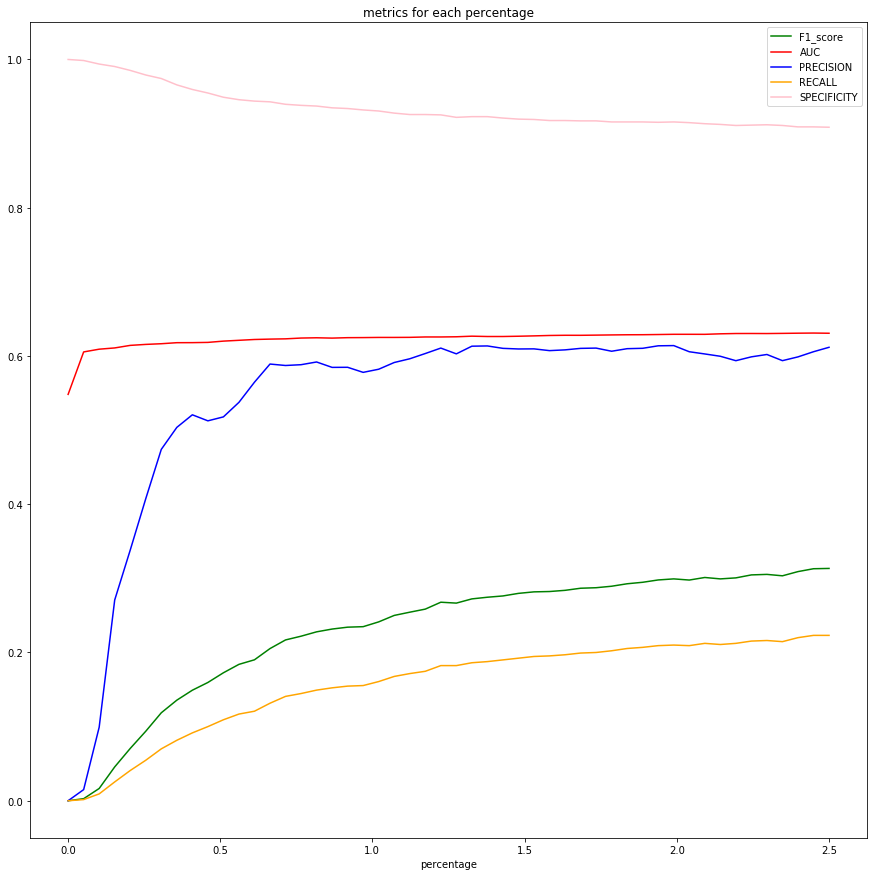

In [31]:
splits = 100
folds= 3
linspace = np.linspace(0.43, 0.55, num=10)
percentages = np.linspace(0.001 , 2.5, 50)

f=[]
auc=[]
precision=[]
recall=[]
specificity=[]

for per in percentages:
    print("percentage:", per)
    F, AUC, PRECISION, RECALL, SPECIFICITY = nested_CV_F_measure(X, y, splits, folds, linspace, dt, per)
    f.append(F)
    auc.append(AUC)
    precision.append(PRECISION)
    recall.append(RECALL)
    specificity.append(SPECIFICITY)

plt.figure(figsize=(15,15))
plt.plot(percentages, f, color='green', label='F1_score')
plt.plot(percentages, auc, color='red', label='AUC')
plt.plot(percentages, precision, color='blue', label='PRECISION')
plt.plot(percentages, recall, color='orange', label='RECALL')
plt.plot(percentages, specificity, color='pink', label='SPECIFICITY')



plt.legend(loc='best')
plt.xlabel('percentage')
plt.title('metrics for each percentage')
plt.show()  
